In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install semopy
import semopy as sem
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
import json
import warnings
warnings.filterwarnings("ignore")
#!pip install git+https://github.com/webermarcolivier/statannot.git
#from statannot import add_stat_annotation
!rm rf statannot
!git clone https://github.com/Ellariel/statannot
from statannot.statannot import add_stat_annotation

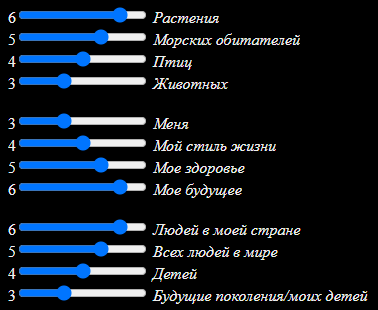

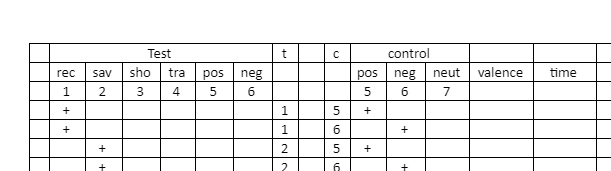


In [3]:
data = pd.read_csv('/content/drive/MyDrive/data.csv', sep=';')
print(len(data), int(len(data) / 32))
rec, sav, sho, tra, pos, neg, neut = 1, 2, 3, 4, 5, 6, 7
eco = [rec, sav, sho, tra]

5248 164


In [4]:
print(len(data.drop_duplicates(subset=['id'])[['age', 'gender', 'income', 'work', 'car']].dropna()))
data.drop_duplicates(subset=['id']).describe().T[17:23]

153


,count,mean,std,min,25%,50%,75%,max
age,160.0,23.718750,7.535386,14.0,19.0,20.0,25.0,55.0
gender,163.0,0.306748,0.462565,0.0,0.0,0.0,1.0,1.0
income,158.0,1.905063,1.329661,1.0,1.0,1.0,2.0,6.0
work,164.0,0.445122,0.498501,0.0,0.0,0.0,1.0,1.0
car,164.0,0.597561,0.491891,0.0,0.0,1.0,1.0,1.0
edu,163.0,2.748466,0.678993,1.0,3.0,3.0,3.0,4.0


In [5]:
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
def make_xy(x, y):
  df = None
  for i in range(len(x)):
    d = pd.DataFrame(y[i])
    d['_group'] = x[i]
    df = pd.concat([df, d], ignore_index=True)
  return df.rename(columns={df.columns[0]:'y', '_group':'x'})

61 - dropout
n=103, inc/con mean diff 74.0 ms, eco-neg/eco-pos mean diff 159.7 ms
congruent time less than incongruent: p=0.005
eco→positive time less than incongruent: p=0.003
eco→negative time greater than congruent: p=0.000
eco→positive time less than eco→negative: p=0.000
congruent vs incongruent (two-sided): p=0.009
eco→positive vs eco→negative(two-sided): p=0.000
♣ rec→positive less eco→negative: p=0.000
♠ sav→positive less eco→negative: p=0.000
♦ sho→positive less eco→negative: p=0.000
♥ tra→positive less eco→negative: p=0.000


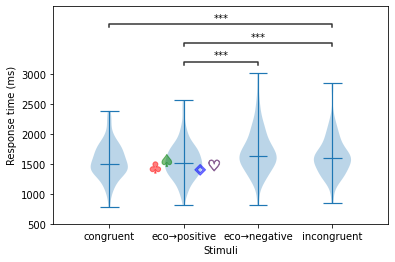

In [6]:
d = data.copy()
invalid = d[d.time > 4000].id.unique() #3500
#d.time = d.time.apply(lambda x: 4000 if x > 4000 else x)
d = d[d.id.apply(lambda x: not x in invalid)]
print(f'{len(invalid)} - dropout')
con = d[((d.test == neg) & (d.ctrl == neg)) |
        ((d.test == pos) & (d.ctrl == pos))].groupby(by=['id']).aggregate(np.mean) #congruent
inc = d[((d.test == neg) & (d.ctrl == pos)) |
        ((d.test == pos) & (d.ctrl == neg))].groupby(by=['id']).aggregate(np.mean) #incongruent
eco_pos = d[d.test.apply(lambda x: x in eco) & (d.ctrl == pos)].groupby(by=['id']).aggregate(np.mean)
eco_neg = d[d.test.apply(lambda x: x in eco) & (d.ctrl == neg)].groupby(by=['id']).aggregate(np.mean)
rec_pos = d[(d.test == rec) & (d.ctrl == pos)].groupby(by=['id']).aggregate(np.mean)
sav_pos = d[(d.test == sav) & (d.ctrl == pos)].groupby(by=['id']).aggregate(np.mean)
sho_pos = d[(d.test == sho) & (d.ctrl == pos)].groupby(by=['id']).aggregate(np.mean)
tra_pos = d[(d.test == tra) & (d.ctrl == pos)].groupby(by=['id']).aggregate(np.mean)
print(f'n={len(con)}, inc/con mean diff {inc.time.mean()-con.time.mean():.1f} ms, eco-neg/eco-pos mean diff {eco_neg.time.mean()-eco_pos.time.mean():.1f} ms')
_, p1 = wilcoxon(con.time, inc.time, alternative='less'); print(f'congruent time less than incongruent: p={p1:.3f}')
_, p2 = wilcoxon(eco_pos.time, inc.time, alternative='less'); print(f'eco→positive time less than incongruent: p={p2:.3f}')
_, p3 = wilcoxon(eco_neg.time, con.time, alternative='greater'); print(f'eco→negative time greater than congruent: p={p3:.3f}')
_, p4 = wilcoxon(eco_pos.time, eco_neg.time, alternative='less'); print(f'eco→positive time less than eco→negative: p={p4:.3f}')
_, p5 = wilcoxon(con.time, inc.time); print(f'congruent vs incongruent (two-sided): p={p5:.3f}')
_, p6 = wilcoxon(eco_pos.time, eco_neg.time); print(f'eco→positive vs eco→negative(two-sided): p={p6:.3f}')

_, p = wilcoxon(rec_pos.time, eco_neg.time, alternative='less'); print(u"\u2663" + f' rec→positive less eco→negative: p={p:.3f}')
_, p = wilcoxon(sav_pos.time, eco_neg.time, alternative='less'); print(u'\u2660' + f' sav→positive less eco→negative: p={p:.3f}')
_, p = wilcoxon(sho_pos.time, eco_neg.time, alternative='less'); print(u'\u2666' + f' sho→positive less eco→negative: p={p:.3f}')
_, p = wilcoxon(tra_pos.time, eco_neg.time, alternative='less'); print(u'\u2665' + f' tra→positive less eco→negative: p={p:.3f}')

fig, ax = plt.subplots()
y = [con.time, eco_pos.time, eco_neg.time, inc.time]
x = ['congruent', 'eco→positive', 'eco→negative', 'incongruent']
v = ax.violinplot(y, showmedians=True, showmeans=False, showextrema=True)
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = v[partname]
    #vp.set_edgecolor(rrred)
    vp.set_linewidth(1.2)
for vp in v['bodies']:
    #vp.set_facecolor(bluuu)
    #vp.set_edgecolor(rrred)
    #vp.set_linewidth(1)
    vp.set_alpha(0.3)
#ax.boxplot(y, sym='', whis=0, widths = 0.2)
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.scatter([1.60], [rec_pos.time.median()], 150, c='r', alpha=0.5, marker=r'$\clubsuit$', label="rec")
ax.scatter([1.75], [sav_pos.time.median()], 150, c='g', alpha=0.5, marker=r'$\spadesuit$', label="sav")
ax.scatter([2.20], [sho_pos.time.median()], 150, c='b', alpha=0.5, marker=r'$\diamond$', label="sho")
ax.scatter([2.40], [tra_pos.time.median()], 150, c=4, alpha=0.5, marker=r'$\heartsuit$', label="tra")
#ax.set_title('Violin Plot')
ax.set_ylabel('Response time (ms)')
ax.set_xlabel('Stimuli')
set_axis_style(ax, x)
xy = make_xy(x, y)
annot = ['***' , '***', '***']
pairs = [(x[0], x[3]), (x[1], x[2]), (x[1], x[3])]
add_stat_annotation(ax, data=xy, x='x', y='y', order=x, box_pairs=pairs, perform_stat_test=False,
                    text_format='star', loc='inside', verbose=0, text_annot_custom=annot,
                    left_offset=1, pvalues=[0.0 for i in pairs])
plt.yticks(np.arange(500, 3500, 500))
#plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.savefig('fig11.png', dpi=300, quality=100, fomat='png')
plt.show()

In [7]:
print(len(eco_pos))
print('Male ',len(eco_pos[eco_pos.gender == 1]))
print('Female ',len(eco_pos[eco_pos.gender != 1]))
eco_pos.describe().T[16:23]

103
Male  34
Female  69


,count,mean,std,min,25%,50%,75%,max
age,99.0,22.808081,6.541355,14.0,19.0,20.0,23.0,50.0
gender,103.0,0.330097,0.472547,0.0,0.0,0.0,1.0,1.0
income,100.0,1.880000,1.304847,1.0,1.0,1.0,2.0,6.0
work,103.0,0.436893,0.498427,0.0,0.0,0.0,1.0,1.0
car,103.0,0.669903,0.472547,0.0,0.0,1.0,1.0,1.0
edu,102.0,2.745098,0.684861,1.0,3.0,3.0,3.0,4.0
device,103.0,0.320388,0.468908,0.0,0.0,0.0,1.0,1.0


40 - dropout
n=124
eco valence median: 3.125
pos vs neg mean diff 0.39 pts
eco vs neg mean diff 0.30 pts
eco vs pos mean diff -0.09 pts
positive valence greater than negative: p=0.000
eco valence greater than negative: p=0.000
positive valence greater than eco: p=0.159
♣ rec valence greater negative: p=0.002
♠ sav valence greater negative: p=0.003
♦ sho valence greater negative: p=0.010
♥ tra valence greater negative: p=0.004


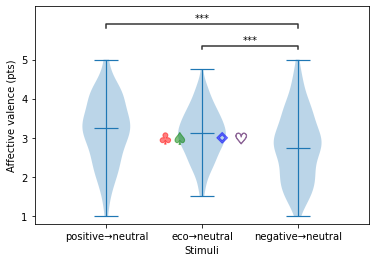

In [8]:
d = data.copy()
a = d[(d.test == neg) & (d.ctrl == neg) & (d.valence > 3)].id.unique()
b = d[(d.test == pos) & (d.ctrl == pos) & (d.valence < 3)].id.unique()
invalid = {*a, *b}
print(f'{len(invalid)} - dropout')
d = d[d.id.apply(lambda x: not x in invalid)]
pos_neut = d[(d.test == pos) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean) #positive-neutral
neg_neut = d[(d.test == neg) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean) #negative-neutral
eco_neut = d[d.test.apply(lambda x: x in eco) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean) #eco-neutral
rec_neut = d[(d.test == rec) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sav_neut = d[(d.test == sav) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sho_neut = d[(d.test == sho) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
tra_neut = d[(d.test == tra) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
print(f'n={len(pos_neut)}')
print(f'eco valence median: {eco_neut.valence.median()}')
print(f'pos vs neg mean diff {pos_neut.valence.mean()-neg_neut.valence.mean():.2f} pts')
print(f'eco vs neg mean diff {eco_neut.valence.mean()-neg_neut.valence.mean():.2f} pts') 
print(f'eco vs pos mean diff {eco_neut.valence.mean()-pos_neut.valence.mean():.2f} pts')
_, p1 = wilcoxon(pos_neut.valence, neg_neut.valence, alternative='greater'); print(f'positive valence greater than negative: p={p1:.3f}')
_, p2 = wilcoxon(eco_neut.valence, neg_neut.valence, alternative='greater'); print(f'eco valence greater than negative: p={p2:.3f}')
_, p3 = wilcoxon(pos_neut.valence, eco_neut.valence, alternative='greater'); print(f'positive valence greater than eco: p={p3:.3f}')

_, p = wilcoxon(rec_neut.valence, neg_neut.valence, alternative='greater'); print(u"\u2663" + f' rec valence greater negative: p={p:.3f}')
_, p = wilcoxon(sav_neut.valence, neg_neut.valence, alternative='greater'); print(u'\u2660' + f' sav valence greater negative: p={p:.3f}')
_, p = wilcoxon(sho_neut.valence, neg_neut.valence, alternative='greater'); print(u'\u2666' + f' sho valence greater negative: p={p:.3f}')
_, p = wilcoxon(tra_neut.valence, neg_neut.valence, alternative='greater'); print(u'\u2665' + f' tra valence greater negative: p={p:.3f}')

fig, ax = plt.subplots()
y = [pos_neut.valence, eco_neut.valence, neg_neut.valence]
x = ['positive→neutral', 'eco→neutral', 'negative→neutral']
v = ax.violinplot(y, showmedians=True, showmeans=False)
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = v[partname]
    #vp.set_edgecolor(rrred)
    vp.set_linewidth(1.2)
for vp in v['bodies']:
    #vp.set_facecolor(bluuu)
    #vp.set_edgecolor(rrred)
    #vp.set_linewidth(1)
    vp.set_alpha(0.3)
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.scatter([1.60], [rec_neut.valence.median()], 150, c='r', alpha=0.5, marker=r'$\clubsuit$', label="rec")
ax.scatter([1.75], [sav_neut.valence.median()], 150, c='g', alpha=0.5, marker=r'$\spadesuit$', label="sav")
ax.scatter([2.20], [sho_neut.valence.median()], 150, c='b', alpha=0.5, marker=r'$\diamond$', label="sho")
ax.scatter([2.40], [tra_neut.valence.median()], 150, c=4, alpha=0.5, marker=r'$\heartsuit$', label="tra")
#ax.set_title('Violin Plot')
ax.set_ylabel('Affective valence (pts)')
ax.set_xlabel('Stimuli')
set_axis_style(ax, x)
xy = make_xy(x, y)
annot = ['***' , '***']
pairs = [(x[0], x[2]), (x[1], x[2])]
add_stat_annotation(ax, data=xy, x='x', y='y', order=x, box_pairs=pairs, perform_stat_test=False,
                    text_format='star', loc='inside', verbose=0, text_annot_custom=annot,
                    left_offset=1, pvalues=[0.0 for i in pairs])
plt.yticks(np.arange(1, 6, 1))
plt.savefig('fig22.png', dpi=300, quality=100, fomat='png')
plt.show()

In [9]:
print(len(eco_neut))
print('Male ',len(eco_neut[eco_neut.gender == 1]))
print('Female ',len(eco_neut[eco_neut.gender != 1]))
eco_pos.describe().T[16:23]

124
Male  32
Female  92


,count,mean,std,min,25%,50%,75%,max
age,99.0,22.808081,6.541355,14.0,19.0,20.0,23.0,50.0
gender,103.0,0.330097,0.472547,0.0,0.0,0.0,1.0,1.0
income,100.0,1.880000,1.304847,1.0,1.0,1.0,2.0,6.0
work,103.0,0.436893,0.498427,0.0,0.0,0.0,1.0,1.0
car,103.0,0.669903,0.472547,0.0,0.0,1.0,1.0,1.0
edu,102.0,2.745098,0.684861,1.0,3.0,3.0,3.0,4.0
device,103.0,0.320388,0.468908,0.0,0.0,0.0,1.0,1.0


In [10]:
d = data.copy()
#d.time = np.log(d.time)
#d.age = np.log(d.age)
a = d[(d.test == neg) & (d.ctrl == neg) & (d.valence > 3)].id.unique()
b = d[(d.test == pos) & (d.ctrl == pos) & (d.valence < 3)].id.unique()
c = d[(d.q1 == 6) & (d.q2 == 5) & (d.q3 == 4) & (d.q4 == 3) & \
      (d.q5 == 3) & (d.q6 == 4) & (d.q7 == 5) & (d.q8 == 6) & \
      (d.q9 == 6) & (d.q10 == 5) & (d.q11 == 4) & (d.q12 == 3)].id.unique()
invalid = {*a, *b, *c}
print(f'{len([i for i in c if i not in {*a, *b}])} - dropout')
print(f'{len(invalid)} - total dropout')
d = d[d.id.apply(lambda x: not x in invalid)]#.dropna() #6 uncomplete
rec_v = d[(d.test == rec) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sav_v = d[(d.test == sav) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sho_v = d[(d.test == sho) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
tra_v = d[(d.test == tra) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
eco_v = d[d.test.apply(lambda x: x in eco) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean) #eco-neutral
print(len(eco_v))
cor_p = pearsonr(eco_v.valence, eco_v.time)
cor_s = spearmanr(eco_v.valence, eco_v.time)   
print(f'Pearson r={cor_p[0]:.3f} p={cor_p[1]:.3f}')
print(f'Spearman r={cor_s[0]:.3f} p={cor_s[1]:.3f}')

15 - dropout
55 - total dropout
109
Pearson r=0.128 p=0.186
Spearman r=0.130 p=0.178


In [11]:
pos_v = eco_v[(eco_v.valence > 3)]
print(len(pos_v))
print('Male ',len(pos_v[pos_v.gender == 1]))
print('Female ',len(pos_v[pos_v.gender != 1]))
pos_v.describe().T[16:23]

53
Male  19
Female  34


,count,mean,std,min,25%,50%,75%,max
age,53.0,23.452830,7.075326,15.0,20.0,20.0,23.0,47.0
gender,53.0,0.358491,0.484146,0.0,0.0,0.0,1.0,1.0
income,52.0,1.980769,1.320879,1.0,1.0,1.0,3.0,6.0
work,53.0,0.396226,0.493793,0.0,0.0,0.0,1.0,1.0
car,53.0,0.452830,0.502533,0.0,0.0,0.0,1.0,1.0
edu,53.0,2.754717,0.676690,1.0,3.0,3.0,3.0,4.0
device,53.0,0.377358,0.489364,0.0,0.0,0.0,1.0,1.0


valence median: 3.0
n=53


                    Value
DoF            212.000000
DoF Baseline   240.000000
chi2           282.558500
chi2 p-value     0.000850
chi2 Baseline  733.828986
CFI              0.857120
GFI              0.614953
AGFI             0.564098
NFI              0.614953
TLI              0.838249
RMSEA            0.080003
AIC             71.337415
BIC            152.119384
LogLik           5.331292


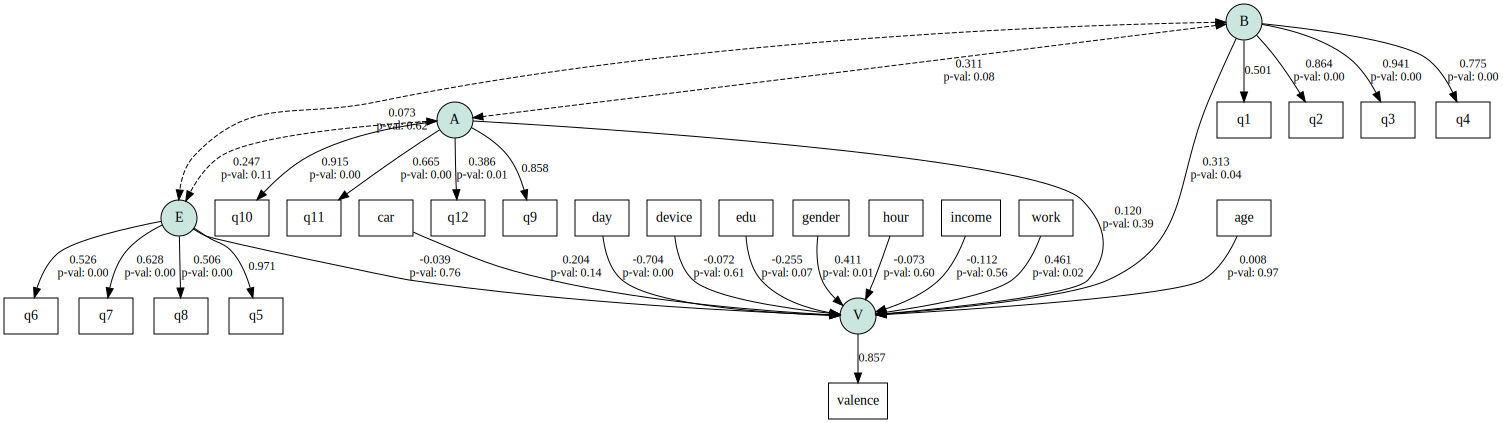

In [14]:
print(f'valence median: {eco_v.valence.median()}')
d = pos_v.copy() #positive
d.time = np.log(d.time)
d.age = np.log(d.age)
print(f'n={len(d)}')
formula = """
B =~ q1 + q2 + q3 + q4
E =~ q5 + q6 + q7 + q8
A =~ q9 + q10 + q11 + q12
V =~ valence
V ~ B + E + A + gender + age + edu + income + car  + work + device + day + hour# + time
"""
model = sem.Model(formula)
model.fit(d, obj="MLW", solver="SLSQP")
print(sem.calc_stats(model).T)#['Value'])
sem.semplot(model, "sem.pdf", plot_covs=True, std_ests=True, show=True)